In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import geopandas as gpd

"""
As preparation for this assignment, you'll spend time finding, loading, processing, assessing, and 
visualizing data in Jupyter notebooks. For the submission, you'll go back and either clean up some
of these notebooks, or create new ones synthesizing the key parts of the exploration you've done. 
The submitted notebooks should intersperse documentation, code, and output to create a clear narrative 
of your work. Only one set of notebooks is expected per team. The easies way to share them with the 
instructors is by uploading to GitHub, which we'll go over in class.
"""

# 1.0 The Goal of this first part is to see what I can do given one street network. 
Next step would be to automate things over many different places and compare the results


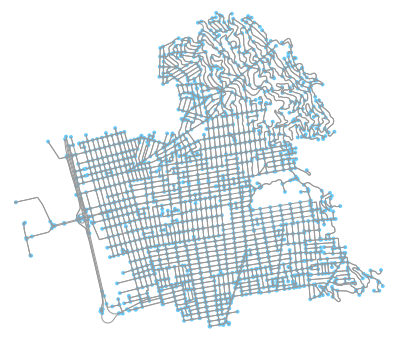

In [2]:
#Obtain Berkeley's road network

Berkeley_network = ox.graph_from_place('Berkeley, California, USA', network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(Berkeley_network))

In [3]:
#Create Dataframe of edges, explore what I can do

Berkeley_Edges=nx.to_pandas_edgelist(Berkeley_network)
Berkeley_Edges.head(3)

,source,target,geometry,lanes,access,tunnel,oneway,maxspeed,junction,length,name,osmid,ref,highway,bridge
0,2820169731,53108131,"LINESTRING (-122.2664168 37.8545455, -122.2663...",NaN,NaN,NaN,False,25 mph,NaN,175.814,Emerson Street,198549475,NaN,residential,NaN
1,2820169731,2820169759,"LINESTRING (-122.2664168 37.8545455, -122.2665...",NaN,NaN,NaN,False,25 mph,NaN,180.766,Emerson Street,198549475,NaN,residential,NaN
2,2820169731,2820169753,"LINESTRING (-122.2664168 37.8545455, -122.2664...","[3, 2]",NaN,NaN,False,25 mph,NaN,83.899,Shattuck Avenue,"[421385008, 417696932]",NaN,tertiary,NaN


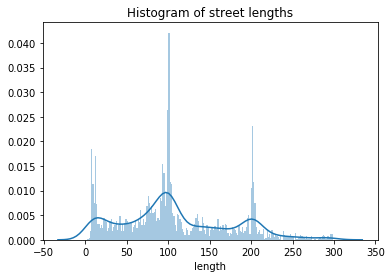

In [4]:
#Looking at the Length of edges

data = Berkeley_Edges.loc[(Berkeley_Edges['length'] < 300)]
    
ax = sns.distplot(a = data.length,
                  bins = 200,
                  kde = True)

ax.set_title('Histogram of street lengths')
plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

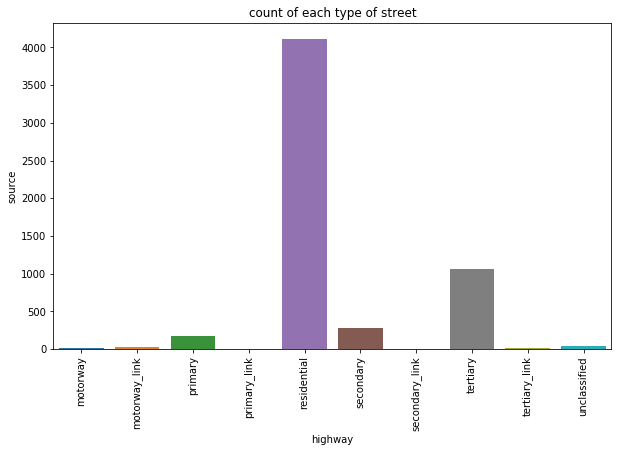

In [5]:
#What are the types of roads in this dataset?

#Making a cleaned dataframe because a few values are the datatype 'list' for some reason. 
#Only selecting rows with strings
Berkeley_Edges_Cleaned_highway = Berkeley_Edges[Berkeley_Edges['highway'].apply(lambda x: isinstance(x, str))]

#New dataframe with a count of each type of edge
roadtypes_count = Berkeley_Edges_Cleaned_highway.groupby('highway')[['source']].count().reset_index()

#Create barplot
f, ax = plt.subplots(figsize=(10, 6))
g=sns.barplot(x='highway', y='source', data=roadtypes_count)
locs, labels = plt.xticks()
ax.set_title('count of each type of street')

plt.setp(labels, rotation=90)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

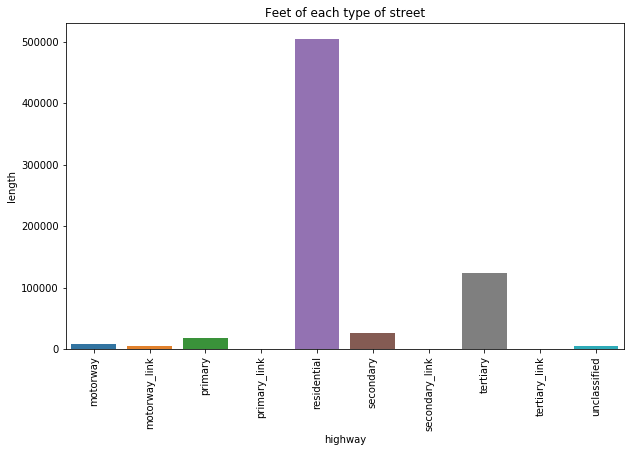

In [6]:
#Note: It would be important to weight the above by length of roads

#New dataframe with a count of each type of edge
roadtypes_count_weighted = Berkeley_Edges_Cleaned_highway.groupby('highway')[['length']].sum().reset_index()

#Create barplot
f, ax = plt.subplots(figsize=(10, 6))
g=sns.barplot(x='highway', y='length', data=roadtypes_count_weighted)
locs, labels = plt.xticks()
ax.set_title('Feet of each type of street')
plt.setp(labels, rotation=90)

[None, None, None, None, None, None, None, None, None, None, None, None]

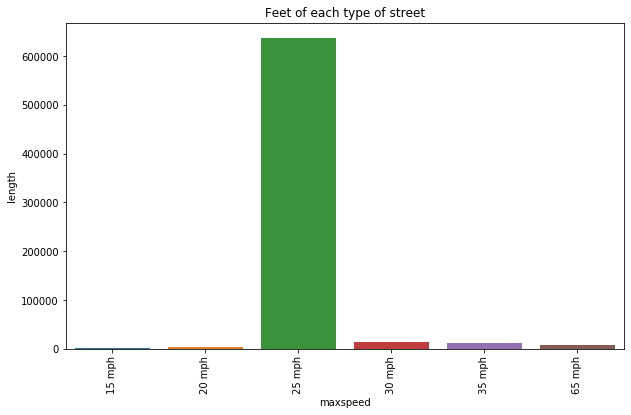

In [7]:
#Replicating the above process, but with speed limits

Berkeley_Edges_Cleaned_speed = Berkeley_Edges[Berkeley_Edges['maxspeed'].apply(lambda x: isinstance(x, str))]
speed_series=pd.Series(Berkeley_Edges_Cleaned_speed['maxspeed'])
speedtypes_count_weighted = Berkeley_Edges_Cleaned_speed.groupby('maxspeed')[['length']].sum().reset_index()
f, ax = plt.subplots(figsize=(10, 6))
g=sns.barplot(x='maxspeed', y='length', data=speedtypes_count_weighted)
locs, labels = plt.xticks()
ax.set_title('Feet of each type of street')
plt.setp(labels, rotation=90)

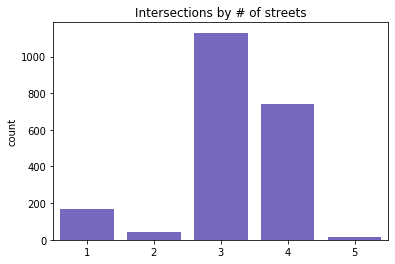

In [10]:
#How many nodes are cul-de-sacs? What is the proportion of 4-way intersections?

#Create a dictionary of node:#_of_streets
Berkeley_nodes_dict=Berkeley_network.graph['streets_per_node']

#Create list of these values
Berkeley_node_list=list(Berkeley_nodes_dict.values())

#Plot these values
data = Berkeley_node_list
    
bx = sns.countplot(x = data, color='slateblue')
bx.set_title('Intersections by # of streets')
plt.show()


# 1.1 Can I turn these into specific metrics?


In [11]:
# % of culs de sacs
culs_de_sacs_pct = 100*Berkeley_node_list.count(1)/len(Berkeley_node_list)
print('culs de sacs % =',culs_de_sacs_pct)

# % of 4-way intersections
four_way_pct = 100*Berkeley_node_list.count(4)/len(Berkeley_node_list)
print('four-way intersection % =',four_way_pct)

culs de sacs % = 8.083689966714218
four-way intersection % = 35.282929148834995


In [12]:
mean_length = Berkeley_Edges['length'].mean()
print('mean length =',mean_length, 'feet')
median_length = Berkeley_Edges['length'].median()
print('median length =',median_length, 'feet')

mean length = 120.86043992349157 feet
median length = 100.375 feet



# 2.0 How do I automate things over many different places and compare the results?


# 2.1 Can I bring in a polygon of a census tract?


In [13]:
# download California census tracts

url = 'https://www2.census.gov/geo/tiger/TIGER2010/TRACT/2010/tl_2010_06_tract10.zip'

with open('tl_2010_06_tract10.zip', 'wb') as f:
    r = requests.get(url)
    f.write(r.content)

In [14]:
# Load the census tracts as a GeoDataFrame

tracts = gpd.read_file('zip://tl_2010_06_tract10.zip')  # 'zip://' prefix clarifies format

In [15]:
tracts.head(2)

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,06,083,002103,06083002103,21.03,Census Tract 21.03,G5020,S,2838200,7603,+34.9306689,-120.4270588,"POLYGON ((-120.41794 34.93834, -120.41766 34.9..."
1,06,083,002402,06083002402,24.02,Census Tract 24.02,G5020,S,16288573,44468,+34.9287963,-120.4780833,"POLYGON ((-120.47389 34.92081, -120.47428 34.9..."


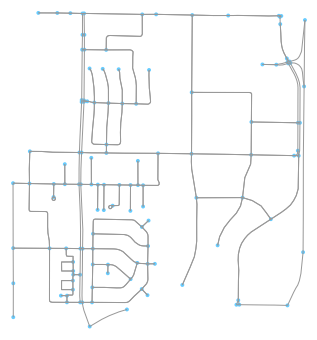

(<Figure size 490.46x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x25557bc3088>)

In [18]:
#Obtain street network of one census tract
one_polygon = tracts.geometry[0]
test_network = ox.graph_from_polygon(one_polygon, network_type='drive')
ox.plot_graph(test_network)

# 2.2 Can I get a list of Alameda census tracts, and calculate metrics for every tract?